In [1]:
# IMPORTS
import random
import numpy as np
import funcionesAuxiliares as fun_aux
import funcionAjuste
import funcionesVisualizacion as fun_vis
import funcionesTest
import matplotlib.pyplot as plt
! pip install joblib
from joblib import Parallel, delayed
! pip install tellurium
import tellurium as te
plt.ion
%matplotlib inline

hrs = np.arange(0,8760,0.1)
print('OK')


You should consider upgrading via the 'C:\Users\Javier\AppData\Local\Programs\Python\Python310\python.exe -m pip install --upgrade pip' command.


You should consider upgrading via the 'C:\Users\Javier\AppData\Local\Programs\Python\Python310\python.exe -m pip install --upgrade pip' command.


OK


# LUZ AM AUTOMATIZADA (v. 9 puntos)

In [2]:
#-----------------------------------------------------------------------------
# LOCALIZACION -> Indicar localizacion (ficheros adjuntos)
Localizacion = 'Albacete'
#-----------------------------------------------------------------------------
# REFERENCIA -> Indicar si se van a usar ficheros de referencia
Referencia = True
# Referencia = False
Latitud = 0
Longitud = 0 
PuntosReferencia = [] # Vector para introducir manualmente los puntos de rs
#-----------------------------------------------------------------------------
# MINIMOS Y MAXIMOS DE CADA ALEATORIO
# Diario (Para aumentar o disminuir radiación base)
MinimoDiario = 0.8
MaximoDiario = 1.15
# Horario (Para simular nubes)
MinimoHorario = 0.75
MaximoHorario = 1
#-----------------------------------------------------------------------------
# AJUSTE -> Activar para quitar hueco en ubicaciones del norte (ajustar horas de dia y noche)
Ajuste = True
epsilonValues = np.arange(-1,1,0.05) # Modificar para el ajuste
# deltaValues = np.arange(-1,1,0.05) # Modificar para el ajuste (NO SE PUEDE PASAR A LA FUNCION QUE PARARELIZA EL BUCLE -> SE DECLARA EN funcionesTest)
#-----------------------------------------------------------------------------
# TEST -> Activar para comprobar la duracion del dia y la noche de cada dia
Test = True
DebugMode = True
#-----------------------------------------------------------------------------

In [3]:
resul_leeReferencia = fun_aux.leeReferencia(Localizacion)
RReferencia = resul_leeReferencia[0]
Latitud = resul_leeReferencia[1]
Longitud =resul_leeReferencia[2]
x1 = resul_leeReferencia[3] # Puntos en los que se toman los datos de referencia

Localizacion: Albacete 
----------------------------------------------
Latitud: 39.001
Longitud: -1.863
Puntos dia: [   0. 1095. 2190. 3285. 4380. 5475. 6570. 7665. 8760.]


In [4]:
resul_calculaFotoperiodo = fun_aux.calcula_y1(Latitud,x1,DebugMode)
y1 = resul_calculaFotoperiodo[0]
Fotoperiodo = resul_calculaFotoperiodo[1]
print(y1)

Horas de sol (fotoperiodo)
--------------------------
 [9.257973275717676, 10.14819820579887, 12.010896638914543, 13.869088338929203, 14.742026724282326, 13.85180179420113, 11.989103361085457, 10.1309116610708, 9.257973275717676] 

y1
--------------------------
 [0.22850222702352696, 0.15431681618342752, -0.0009080532428786814, -0.15575736157743347, -0.22850222702352707, -0.1543168161834274, 0.0009080532428785704, 0.15575736157743336, 0.22850222702352696] 

[0.22850222702352696, 0.15431681618342752, -0.0009080532428786814, -0.15575736157743347, -0.22850222702352707, -0.1543168161834274, 0.0009080532428785704, 0.15575736157743336, 0.22850222702352696]


87600


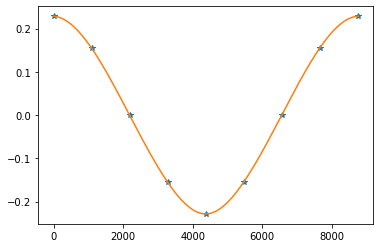

In [5]:
hsol = funcionAjuste.ajuste(y1,x1) # el ajuste se ha cambiado por una interpolacion cubica (parece que los resultados salen mucho mejor)
plt.plot(x1,y1,'*',hrs,hsol)
print(len(hsol))

In [6]:
resul_calculay23 = fun_aux.calcula_y23(RReferencia,y1,DebugMode)
y2 = resul_calculay23[0]
y3 = resul_calculay23[1]

y2
--------------------------
 [0.717502227023527, 0.8238882447548561, 0.9113776610428357, 0.8415283527082809, 0.7932120586907585, 0.8429688981022869, 0.9131937675285929, 0.825328790148862, 0.717502227023527] 

y3
--------------------------
 [0.489, 0.6695714285714286, 0.9122857142857144, 0.9972857142857143, 1.0217142857142856, 0.9972857142857143, 0.9122857142857144, 0.6695714285714286, 0.489] 



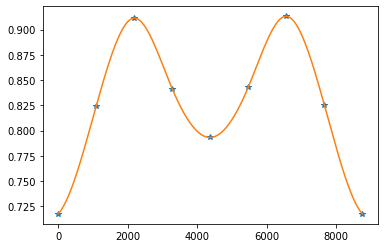

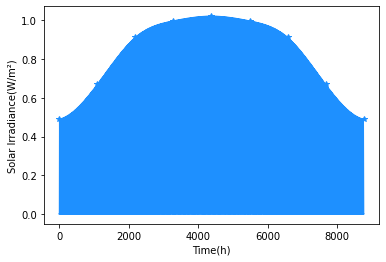

In [7]:
Ac2 = funcionAjuste.ajuste(y2,x1)
plt.plot(x1,y2,'*',hrs,Ac2)
s = fun_aux.calculaRadiacion(Ac2, hsol)
fun_vis.muestraRadiacion(x1,y3,s)

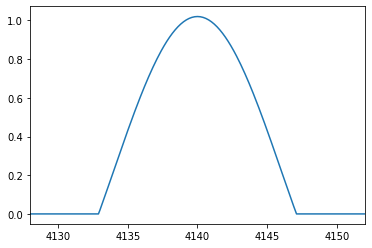

In [8]:
plt.xlim(172*24,173*24)
plt.plot(hrs,s)

### RESULTADOS ANTES DEL AJUSTE

In [9]:
# Antes del ajuste con un margen de error del 30% en 1 hora
funcionesTest.ejecutaTest(Test,DebugMode,Latitud,s)

0 
------------------------------------------------
9.257973275717676  9.5 -> OK( 0.24202672428232397 )

1 
------------------------------------------------
9.258687329084042  9.5 -> OK( 0.2413126709159581 )

2 
------------------------------------------------
9.260352931622833  9.5 -> OK( 0.23964706837716676 )

3 
------------------------------------------------
9.262968831952366  9.5 -> OK( 0.23703116804763447 )

4 
------------------------------------------------
9.266533067542042  9.5 -> OK( 0.2334669324579579 )

5 
------------------------------------------------
9.27104296992408  9.5 -> OK( 0.22895703007591983 )

6 
------------------------------------------------
9.276495171758112  9.5 -> OK( 0.22350482824188767 )

7 
------------------------------------------------
9.282885615710036  9.5 -> OK( 0.21711438428996388 )

8 
------------------------------------------------
9.290209565096973  9.7 -> ********FALLO( 0.4097904349030266 )********

9 
-------------------------------------

In [10]:
def ajusteDeltaEpsilon(epsilon):
    mejorSuma = 1000000
    deltaValues=np.arange(-1,1,0.05)
    for delta in deltaValues:
            duracion = 0
            duracionInvierno = 0

            sAjuste = funcionesTest.radAjustada(y1,y2,x1,delta,epsilon)

            for i in sAjuste[43800:44040]: 
                if i == 0:
                    duracion = duracion + 1
            duracion = duracion/10
            diferenciaAUX = abs((24 - max(Fotoperiodo))-duracion)
            
            for i in sAjuste[0:240]:
                if i == 0:
                    duracionInvierno = duracionInvierno + 1
            duracionInvierno = duracionInvierno/10
            diferenciaAUXinvierno = abs((24 - min(Fotoperiodo))-duracionInvierno)
            sumaAUX = diferenciaAUXinvierno + diferenciaAUX
            
            if sumaAUX < mejorSuma:
                mejorSuma = sumaAUX
                mejorEpsilon = epsilon
                mejorDelta = delta
                if DebugMode:
                    print('MEJOR SUMA = ', mejorSuma, '-->',mejorEpsilon,'|',mejorDelta,'\n')
                
    return mejorSuma,mejorEpsilon, mejorDelta

In [11]:
if Ajuste:
    results = Parallel(n_jobs=-1, verbose=1, backend="threading")(map(delayed(ajusteDeltaEpsilon), epsilonValues))
    minimo = 100000
    for i in range(len(results)):
        if results[i][0] < minimo:
            minimo = results[i][0] 
            print('MEJOR SUMA = ', results[i][0], '-->',results[i][1],'|',results[i][2],'\n')
            mejorepsilon = results[i][1]
            mejordelta = results[i][2]
else:
    print('Test desactivado')

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.


MEJOR SUMA =  24.0 --> -0.5499999999999996 | -1.0 

MEJOR SUMA =  24.0 --> -0.8999999999999999 | -1.0 

MEJOR SUMA =  24.0 --> -0.6499999999999997 | -1.0 

MEJOR SUMA =  24.0 --> -0.6999999999999997 | -1.0 

MEJOR SUMA =  24.0 --> -0.8499999999999999 | -1.0 

MEJOR SUMA =  24.0 --> -0.95 | -1.0 

MEJOR SUMA =  24.0 --> -1.0 | -1.0 

MEJOR SUMA =  24.0 --> -0.5999999999999996 | -1.0 

MEJOR SUMA =  24.0 --> -0.7999999999999998 | -1.0 

MEJOR SUMA =  24.0 --> -0.49999999999999956 | -1.0 

MEJOR SUMA =  24.0 --> -0.4499999999999995 | -1.0 

MEJOR SUMA =  24.0 --> -0.7499999999999998 | -1.0 

MEJOR SUMA =  20.0 --> -0.8999999999999999 | -0.4499999999999995 

MEJOR SUMA =  20.0 --> -0.8499999999999999 | -0.4499999999999995 

MEJOR SUMA =  19.799999999999997 --> -0.49999999999999956 | -0.4499999999999995 

MEJOR SUMA =  20.0 --> -0.95 | -0.4499999999999995 

MEJOR SUMA =  16.599999999999998 --> -0.8499999999999999 | -0.39999999999999947 

MEJOR SUMA =  16.599999999999998 --> -0.4999999999999

[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:  2.6min finished


### RESULTADOS DESPUES DEL AJUSTE

0 
------------------------------------------------
9.257973275717676  9.1 -> OK( 0.1579732757176764 )

1 
------------------------------------------------
9.258687329084042  9.1 -> OK( 0.15868732908404226 )

2 
------------------------------------------------
9.260352931622833  9.1 -> OK( 0.1603529316228336 )

3 
------------------------------------------------
9.262968831952366  9.1 -> OK( 0.1629688319523659 )

4 
------------------------------------------------
9.266533067542042  9.2 -> OK( 0.0665330675420428 )

5 
------------------------------------------------
9.27104296992408  9.3 -> OK( 0.028957030075920542 )

6 
------------------------------------------------
9.276495171758112  9.3 -> OK( 0.023504828241888376 )

7 
------------------------------------------------
9.282885615710036  9.3 -> OK( 0.01711438428996459 )

8 
------------------------------------------------
9.290209565096973  9.3 -> OK( 0.009790434903028 )

9 
------------------------------------------------
9.298461

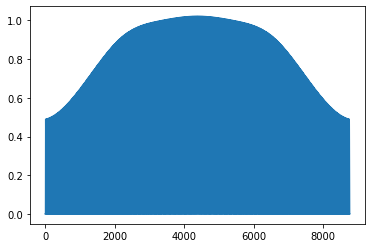

In [12]:
if Ajuste:
    s = funcionesTest.radAjustada(y1,y2,x1,mejordelta,mejorepsilon)
    plt.plot(hrs,s)
    funcionesTest.ejecutaTest(Test,DebugMode,Latitud,s)

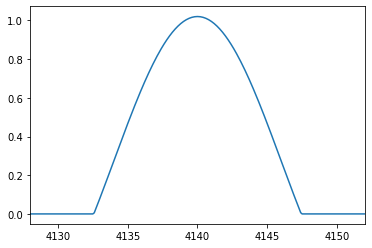

In [13]:
plt.xlim(172*24,173*24)
plt.plot(hrs,s)

### RESULTADOS CON ALEATORIOS

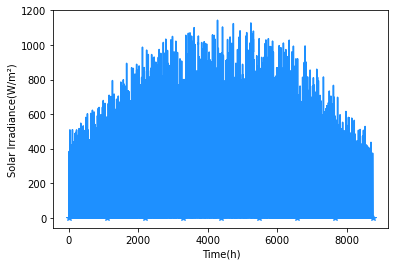

In [14]:
sFinal = []
for dia in range(0,365,1):
    randomDiario = random.uniform(MinimoDiario,MaximoDiario)
    for hora in range(0,24,1):
        randomHorario = random.uniform(MinimoHorario,MaximoHorario)
        for i in range(0,10,1):
            #print((hora*10+i)+240*dia)
            sFinal.append(s[(hora*10+i)+240*dia]*1000*randomDiario*randomHorario)
fun_vis.muestraRadiacion(x1,y3,sFinal)

87600


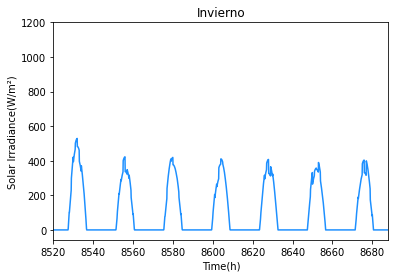

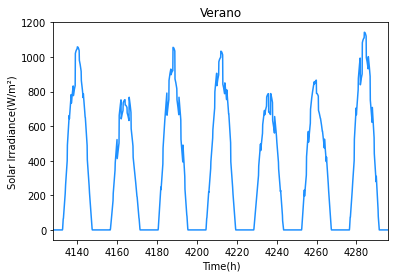

In [15]:
print(len(sFinal))
fun_vis.muestraInvierno(x1,y3,sFinal)
fun_vis.muestraVerano(x1,y3,sFinal)

In [16]:
fsalida = open('radiacion_eventos.txt', 'w')
cont = 0
for i in range(87600):
    if sFinal[i] != 0:
        fsalida.write('at (time >= %f && time < %f): F1AUX = %f\n'%(i/10,(i+1)/10,sFinal[i]))
        ultimo = i-1
    if i == 0:
        i_inicial = 0
    if i != 0 and i!= 87599:
        if sFinal[i] == 0 and sFinal[i-1] != 0:
            i_inicial = i

        if sFinal[i] == 0 and sFinal[i+1] != 0:
            i_final = i
            fsalida.write('at (time >= %f && time < %f): F1AUX = 0.0\n'%(i_inicial/10,i_final/10))
               
fsalida.write('end\n')
fsalida.close()
print('TERMINADO')

TERMINADO


In [17]:
filenames = ['modeloFinal.txt','radiacion_eventos.txt'] 
with open('modeloFinal_v2.txt', 'w') as outfile: 
    for fname in filenames: 
        with open(fname) as infile: 
            for line in infile: 
                outfile.write(line)

In [18]:

import time
tic = time.perf_counter()
print('Cargando fichero...')
model = te.loada('modeloFinal_v2.txt')
toc = time.perf_counter()
print(f'Fichero cargado en {toc - tic:0.2f} segundos')

Cargando fichero...
Fichero cargado en 1912.72 segundos


In [19]:
n = 8760
print('Realizando simulaciones, espere por favor...')
tic = time.perf_counter()
model.resetAll()
simulation_result_especies = model.simulate(0.1,n,10*n+1)
print('1/2')
toc = time.perf_counter()
print(f'Simulacion ejecutada en {toc - tic:0.2f} segundos')

Realizando simulaciones, espere por favor...
1/2
Simulacion ejecutada en 6217.77 segundos


In [ ]:
n = 8760
print('Realizando simulaciones, espere por favor...')
tic = time.perf_counter()
model.resetAll()
simulation_result_F1 = model.simulate(0.1,n,10*n+1,['time','F1_ORIGINAL'])
print('2/2')
toc = time.perf_counter()
print(f'Simulacion ejecutada en {toc - tic:0.2f} segundos')

In [ ]:
#print(simulation_result_especies)

In [20]:
fsalida = open('resultados.txt', 'w')
str = repr(simulation_result_especies)
fsalida.write(str)
fsalida.close()

fsalida = open('resultadosF1.txt', 'w')
str = repr(simulation_result_F1)
fsalida.write(str)
fsalida.close()

In [21]:
fichero = "resultados.txt"
with open(fichero,'r', encoding='utf-8') as f:
    data = f.read()
    data = data.replace("[", "")
    data = data.replace("]", "")
    data = data.replace(" ", "")
    with open(fichero,'w', encoding='utf-8') as f2:
        f2.write(data)